## Goals
1. Enumerate the per-session HDF5 files and summarize the number of trials, sequence lengths, and time steps.
2. Visualize distributions across sessions and splits (train/val/test).
3. Inspect an example trial to see the available attributes, target text, and feature matrices.

In [1]:
from pathlib import Path
from typing import Iterable
import re
from collections import Counter

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")
pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 20)

In [2]:
DATA_ROOT = Path("../data/hdf5_data_final").resolve()
SESSION_LIMIT = 6  # Increase or set to None to scan every available session.
SPLIT_FILES = {
    "train": "data_train.hdf5",
    "val": "data_val.hdf5",
    "test": "data_test.hdf5",
}
assert DATA_ROOT.exists(), f"Missing data directory: {DATA_ROOT}"
DATA_ROOT

WindowsPath('D:/WInFolders/Desktop/MSc/Fall 2025/Comp Tools/brain-to-text/src/data/hdf5_data_final')

### Helper utilities
Functions below iterate over the t15.* directories, read trial-level attributes, and emit tidy records that can be converted into a `pandas` DataFrame for analysis.

In [3]:
def list_session_dirs(data_root: Path, limit: int | None) -> list[Path]:
    sessions = sorted(p for p in data_root.glob("t15.*") if p.is_dir())
    return sessions[:limit] if limit else sessions


def summarize_trials(file_path: Path, session: str, split: str) -> list[dict]:
    records: list[dict] = []
    with h5py.File(file_path, "r") as h5_file:
        for trial_key in sorted(h5_file.keys()):
            if not trial_key.startswith("trial_"):
                continue
            group = h5_file[trial_key]
            attrs = {key: group.attrs[key] for key in group.attrs}
            record = {
                "session": session,
                "split": split,
                "trial_key": trial_key,
                "file_path": str(file_path),
                "block_num": int(attrs.get("block_num", -1)),
                "n_time_steps": int(attrs.get("n_time_steps", group["input_features"].shape[0] if "input_features" in group else -1)),
                "seq_len": int(attrs["seq_len"]) if "seq_len" in attrs else np.nan,
                "sentence_label": attrs.get("sentence_label"),
            }
            record["sentence_char_len"] = (
                len(record["sentence_label"]) if record["sentence_label"] is not None else np.nan
            )
            features = group.get("input_features")
            if features is not None:
                record["input_steps"] = features.shape[0]
                record["feature_dim"] = features.shape[1] if features.ndim == 2 else np.nan
            else:
                record["input_steps"] = np.nan
                record["feature_dim"] = np.nan
            record["has_seq_targets"] = all(name in group for name in ("seq_class_ids", "transcription"))
            records.append(record)
    return records


def collect_metadata(data_root: Path, limit: int | None) -> pd.DataFrame:
    records: list[dict] = []
    for session_dir in list_session_dirs(data_root, limit):
        for split, filename in SPLIT_FILES.items():
            file_path = session_dir / filename
            if not file_path.exists():
                continue
            records.extend(summarize_trials(file_path, session_dir.name, split))
    df = pd.DataFrame.from_records(records)
    if df.empty:
        return df
    df["has_transcript"] = df["sentence_label"].notna()
    df["session_date"] = pd.to_datetime(
        df["session"].str.replace("t15.", "", regex=False), format="%Y.%m.%d"
    )
    return df

In [4]:
metadata_df = collect_metadata(DATA_ROOT, SESSION_LIMIT)
print(f"Collected {len(metadata_df)} trials across {metadata_df['session'].nunique()} sessions")
metadata_df.head()

Collected 1715 trials across 6 sessions


,session,split,trial_key,file_path,block_num,n_time_steps,seq_len,sentence_label,sentence_char_len,input_steps,feature_dim,has_seq_targets,has_transcript,session_date
0,t15.2023.08.11,train,trial_0000,D:\WInFolders\Desktop\MSc\Fall 2025\Comp Tools...,2,321,14.0,Bring it closer.,16.0,321,512,True,True,2023-08-11
1,t15.2023.08.11,train,trial_0001,D:\WInFolders\Desktop\MSc\Fall 2025\Comp Tools...,2,481,19.0,My family is closer.,20.0,481,512,True,True,2023-08-11
2,t15.2023.08.11,train,trial_0002,D:\WInFolders\Desktop\MSc\Fall 2025\Comp Tools...,2,480,14.0,What do they like?,18.0,480,512,True,True,2023-08-11
3,t15.2023.08.11,train,trial_0003,D:\WInFolders\Desktop\MSc\Fall 2025\Comp Tools...,2,502,14.0,How is that good?,17.0,502,512,True,True,2023-08-11
4,t15.2023.08.11,train,trial_0004,D:\WInFolders\Desktop\MSc\Fall 2025\Comp Tools...,2,402,13.0,Need help here?,15.0,402,512,True,True,2023-08-11


In [5]:
if metadata_df.empty:
    raise RuntimeError("No records were collected. Check DATA_ROOT/SESSION_LIMIT.")

summary = metadata_df.groupby(["session", "split"]).agg(
    n_trials=("trial_key", "count"),
    avg_time_steps=("n_time_steps", "mean"),
    median_time_steps=("n_time_steps", "median"),
    avg_seq_len=("seq_len", "mean"),
    has_transcript_pct=("has_transcript", "mean"),
    avg_sentence_chars=("sentence_char_len", "mean"),
    feature_dim=("feature_dim", "first"),
).reset_index()
summary["has_transcript_pct"] = (summary["has_transcript_pct"] * 100).round(1)
summary.round(2)

,session,split,n_trials,avg_time_steps,median_time_steps,avg_seq_len,has_transcript_pct,avg_sentence_chars,feature_dim
0,t15.2023.08.11,train,288,545.43,527.5,16.58,100.0,19.43,512
1,t15.2023.08.13,test,35,671.43,638.0,NaN,0.0,NaN,512
2,t15.2023.08.13,train,348,752.20,729.0,24.76,100.0,29.06,512
3,t15.2023.08.13,val,35,731.63,733.0,27.49,100.0,32.31,512
4,t15.2023.08.18,test,50,787.32,808.0,NaN,0.0,NaN,512
5,t15.2023.08.18,train,197,885.52,851.0,26.80,100.0,31.52,512
6,t15.2023.08.18,val,49,709.47,705.0,24.35,100.0,28.65,512
7,t15.2023.08.20,test,49,721.96,705.0,NaN,0.0,NaN,512
8,t15.2023.08.20,train,278,797.99,765.5,26.40,100.0,30.96,512
9,t15.2023.08.20,val,48,729.54,701.0,26.23,100.0,30.83,512


### Distribution snapshots
The next cells highlight how neural sequence durations and text lengths vary across splits in the sampled sessions.

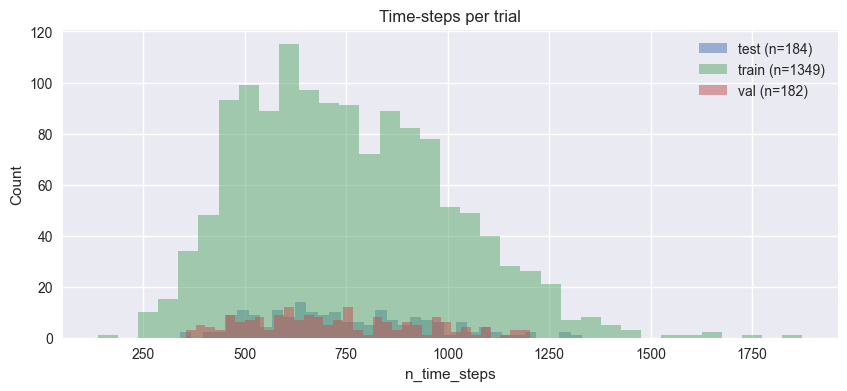

In [6]:
fig, ax = plt.subplots(figsize=(10, 4))
for split, subset in metadata_df.dropna(subset=["n_time_steps"]).groupby("split"):
    ax.hist(subset["n_time_steps"], bins=35, alpha=0.5, label=f"{split} (n={len(subset)})")
ax.set_title("Time-steps per trial")
ax.set_xlabel("n_time_steps")
ax.set_ylabel("Count")
ax.legend()
plt.show()

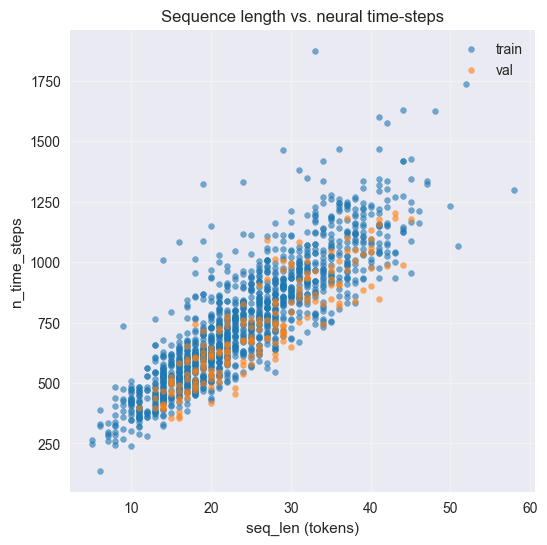

In [7]:
paired = metadata_df.dropna(subset=["seq_len", "n_time_steps"])
fig, ax = plt.subplots(figsize=(6, 6))
colors = {"train": "tab:blue", "val": "tab:orange", "test": "tab:green"}
for split, subset in paired.groupby("split"):
    ax.scatter(subset["seq_len"], subset["n_time_steps"], s=18, alpha=0.6, c=colors.get(split, "gray"), label=split)
ax.set_title("Sequence length vs. neural time-steps")
ax.set_xlabel("seq_len (tokens)")
ax.set_ylabel("n_time_steps")
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()

In [27]:
# Calculate correlation between seq_len and n_time_steps for all samples
correlation = paired["seq_len"].corr(paired["n_time_steps"])
print(f"Correlation between seq_len and n_time_steps: {correlation:.4f}")

Correlation between seq_len and n_time_steps: 0.8674


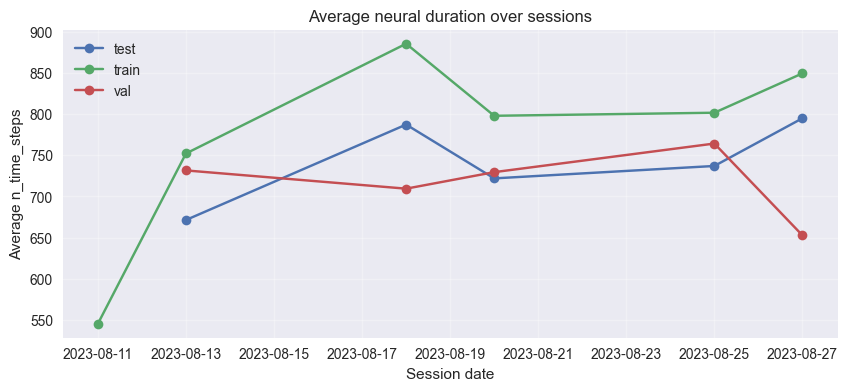

In [9]:
timeline = (
    metadata_df.dropna(subset=["n_time_steps"])
    .groupby(["session_date", "split"])
    .agg(avg_time_steps=("n_time_steps", "mean"))
    .reset_index()
)
fig, ax = plt.subplots(figsize=(10, 4))
for split, subset in timeline.groupby("split"):
    ax.plot(subset["session_date"], subset["avg_time_steps"], marker="o", label=split)
ax.set_title("Average neural duration over sessions")
ax.set_xlabel("Session date")
ax.set_ylabel("Average n_time_steps")
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

### Inspect a concrete trial
Below we grab the first trial that contains both neural features and sequence targets, display its metadata, and render a compact heatmap of the high-dimensional feature activations.

In [10]:
sample = metadata_df.query('has_seq_targets')
if sample.empty:
    raise RuntimeError("No trial with seq targets found in selected sessions.")
sample_row = sample.iloc[0]
print(
    f"Session: {sample_row.session} | Split: {sample_row.split} | Trial: {sample_row.trial_key}"
)
print(f"Sentence label: {sample_row.sentence_label}")
with h5py.File(sample_row.file_path, 'r') as h5_file:
    trial_group = h5_file[sample_row.trial_key]
    sample_features = trial_group['input_features'][:]
    seq_targets = trial_group['seq_class_ids'][:sample_row.seq_len.astype(int) if not np.isnan(sample_row.seq_len) else 0]
print(f"Feature matrix shape: {sample_features.shape}")
print(f"First 10 seq_class_ids: {seq_targets[:10]}")

Session: t15.2023.08.11 | Split: train | Trial: trial_0000
Sentence label: Bring it closer.
Feature matrix shape: (321, 512)
First 10 seq_class_ids: [ 7 28 17 24 40 17 31 40 20 21]


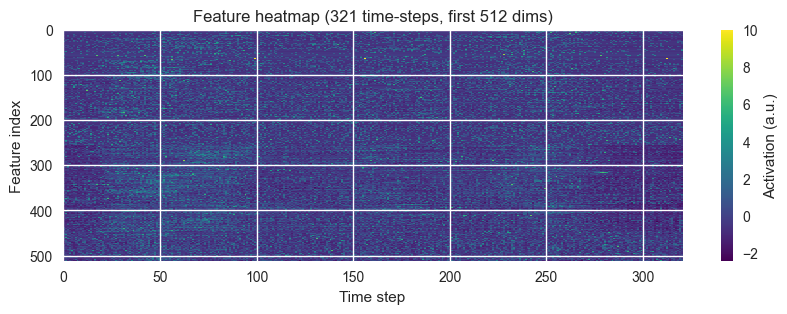

In [11]:
if 'sample_features' in globals():
    max_time = min(400, sample_features.shape[0])
    fig, ax = plt.subplots(figsize=(10, 3))
    im = ax.imshow(sample_features[:max_time].T, aspect='auto', cmap='viridis', interpolation='nearest')
    ax.set_title(f"Feature heatmap ({max_time} time-steps, first {sample_features.shape[1]} dims)")
    ax.set_xlabel('Time step')
    ax.set_ylabel('Feature index')
    plt.colorbar(im, ax=ax, label='Activation (a.u.)')
else:
    print('sample_features not defined')

### Text-level characteristics
We extend the analysis by quantifying lexical properties of each annotated sentence and linking them back to their neural samples.

In [18]:
TOKEN_PATTERN = re.compile(r"[A-Za-z']+")

def tokenize_sentence(text: str) -> list[str]:
    return TOKEN_PATTERN.findall(text.lower())

text_df = metadata_df.dropna(subset=["sentence_label"]).copy()
text_df["word_tokens"] = text_df["sentence_label"].apply(tokenize_sentence)
text_df["word_count"] = text_df["word_tokens"].str.len()
text_df = text_df[text_df["word_count"] > 0].copy()
text_df["unique_word_count"] = text_df["word_tokens"].apply(lambda tokens: len(set(tokens)))
text_df["char_count"] = text_df["sentence_label"].str.len()
text_df["frames_per_word"] = text_df["n_time_steps"] / text_df["word_count"]
text_df["chars_per_word"] = text_df["char_count"] / text_df["word_count"]
text_df["frames_per_char"] = text_df["n_time_steps"] / text_df["char_count"]
text_df["seq_word_gap"] = np.where(
    text_df["seq_len"].notna(), text_df["seq_len"] - text_df["word_count"], np.nan
)

# Calculate average num of sentences per trial
avg_sentences_per_trial = text_df.groupby("trial_key")["sentence_label"].count().mean()

text_split_summary = (
    text_df.groupby("split")
    .agg(
        n_trials=("trial_key", "count"),
        median_words=("word_count", "median"),
        avg_words=("word_count", "mean"),
        avg_chars=("char_count", "mean"),
        avg_frames=("n_time_steps", "mean"),
        avg_frames_per_word=("frames_per_word", "mean"),
        avg_chars_per_word=("chars_per_word", "mean"),
        avg_seq_word_gap=("seq_word_gap", "mean"),
        avg_unique_words=("unique_word_count", "count")
    )
    .round(2)
)

text_split_summary

,n_trials,median_words,avg_words,avg_chars,avg_frames,avg_frames_per_word,avg_chars_per_word,avg_seq_word_gap,avg_unique_words
split,,,,,,,,,
train,1349,5.0,5.67,28.18,751.01,135.73,5.04,18.34,1349
val,182,6.0,6.02,30.34,718.76,123.20,5.21,19.80,182


In [25]:
avg_sentences_per_trial_split = (
    text_df.groupby(["split", "trial_key"])["sentence_label"]
    .count()
    .groupby("split")
    .mean()
)
avg_sentences_per_trial_split

split
train    3.876437
val      3.714286
Name: sentence_label, dtype: float64

C:\Users\Leire\AppData\Local\Temp\ipykernel_8960\3950841938.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(box_data, labels=box_labels, showmeans=True)


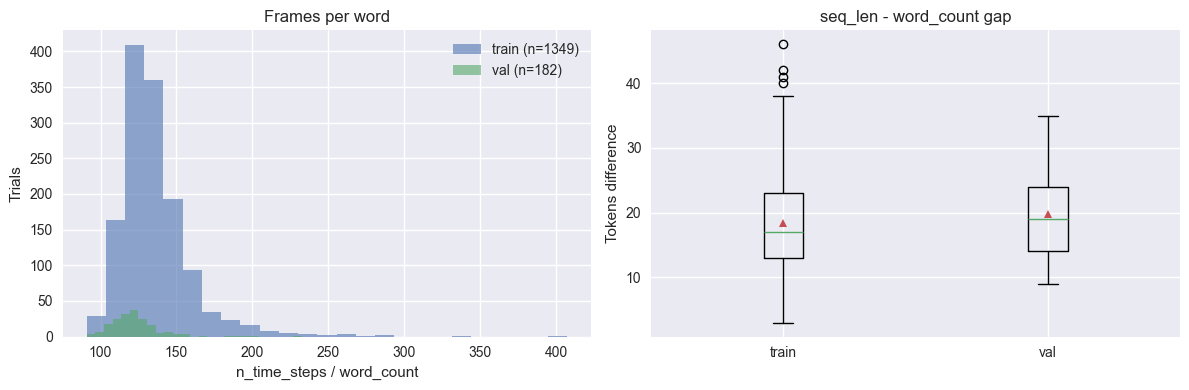

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for split, subset in text_df.groupby("split"):
    axes[0].hist(
        subset["frames_per_word"], bins=25, alpha=0.6, label=f"{split} (n={len(subset)})"
    )
axes[0].set_title("Frames per word")
axes[0].set_xlabel("n_time_steps / word_count")
axes[0].set_ylabel("Trials")
axes[0].legend()

box_data = [subset["seq_word_gap"].dropna() for _, subset in text_df.groupby("split") if not subset["seq_word_gap"].dropna().empty]
box_labels = [split for split, subset in text_df.groupby("split") if not subset["seq_word_gap"].dropna().empty]
if box_data:
    axes[1].boxplot(box_data, labels=box_labels, showmeans=True)
    axes[1].set_title("seq_len - word_count gap")
    axes[1].set_ylabel("Tokens difference")
else:
    axes[1].axis("off")
    axes[1].text(0.5, 0.5, "No seq_len annotations for plotted splits", ha="center")
plt.tight_layout()
plt.show()

In [11]:
token_counter = Counter()
bigram_counter = Counter()
for tokens in text_df["word_tokens"]:
    token_counter.update(tokens)
    bigram_counter.update([" ".join(pair) for pair in zip(tokens, tokens[1:])])

word_freq = pd.DataFrame(token_counter.most_common(20), columns=["word", "count"])
bigram_freq = pd.DataFrame(bigram_counter.most_common(15), columns=["bigram", "count"])

word_freq, bigram_freq

(    word  count
 0      i    380
 1    the    266
 2      a    236
 3    you    234
 4     it    213
 5     to    203
 6   that    154
 7     of    151
 8   they    150
 9     is    149
 10    do    144
 11  have    128
 12   not    125
 13    my    122
 14    in    102
 15   and     88
 16  it's     81
 17   are     80
 18   was     77
 19  like     71,
        bigram  count
 0      do you     41
 1   my family     32
 2      i hope     31
 3        i am     30
 4     i don't     30
 5    my nurse     29
 6      in the     28
 7     i think     28
 8       a lot     28
 9      do not     27
 10    tell my     26
 11     lot of     25
 12   you have     24
 13   they are     24
 14     i have     24)

Removing the stop-words from the most frequent words

In [12]:
# Remove stopwords from counters
import nltk

nltk.download('stopwords')
nltk_stopwords = set(nltk.corpus.stopwords.words('english'))

for stopword in nltk_stopwords:
    if stopword in token_counter:
        del token_counter[stopword]

word_freq_nonstop = pd.DataFrame(token_counter.most_common(20), columns=["word", "count"])

word_freq_nonstop

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Leire\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,word,count
0,like,71
1,good,62
2,hope,54
3,think,46
4,really,46
5,family,42
6,going,41
7,one,40
8,tell,39
9,need,37


#### Vocabulary type statistics

The dataset creators provided an extra description csv file stating some information about each of the trials. One of them was the vocabulary used to create the sentences.

In [14]:
file = "../data/t15_copyTaskData_description.csv"

# Load the data from the CSV file to pandas DataFrame
import pandas as pd

data = pd.read_csv(file)
print(data.head())

# Calculate "Number of sentences" per "Corpus"

for corpus in data["Corpus"].unique():
    subset = data[data["Corpus"] == corpus]
    total_sentences = subset["Number of sentences"].sum()
    print(f"Corpus: {corpus}, Total Sentences: {total_sentences}")
    # Get train/test split
    train_data = subset[subset["Split"] == "Train"]
    test_data = subset[subset["Split"] == "Val/Test"]
    train_sentences = train_data["Number of sentences"].sum()
    test_sentences = test_data["Number of sentences"].sum()
    print(f"  Train Sentences: {train_sentences}, Val/Test Sentences: {test_sentences}")

         Date  Post-implant day  Block number  Number of sentences   Corpus  \
0  2023-08-11                25             2                   20  50-Word   
1  2023-08-11                25             3                   30  50-Word   
2  2023-08-11                25             4                   40  50-Word   
3  2023-08-11                25             5                   50  50-Word   
4  2023-08-11                25             6                   50  50-Word   

   Split  
0  Train  
1  Train  
2  Train  
3  Train  
4  Train  
Corpus: 50-Word, Total Sentences: 1091
  Train Sentences: 1091, Val/Test Sentences: 0
Corpus: Switchboard, Total Sentences: 7672
  Train Sentences: 5533, Val/Test Sentences: 2139
Corpus: Openwebtext, Total Sentences: 172
  Train Sentences: 0, Val/Test Sentences: 172
Corpus: Random, Total Sentences: 79
  Train Sentences: 0, Val/Test Sentences: 79
Corpus: Harvard, Total Sentences: 98
  Train Sentences: 0, Val/Test Sentences: 98
Corpus: Freq words, Total Sen

### Sample dynamics visualizations
We extend the sample-level deep dive with additional plots that contrast multiple trials and highlight temporal structure.

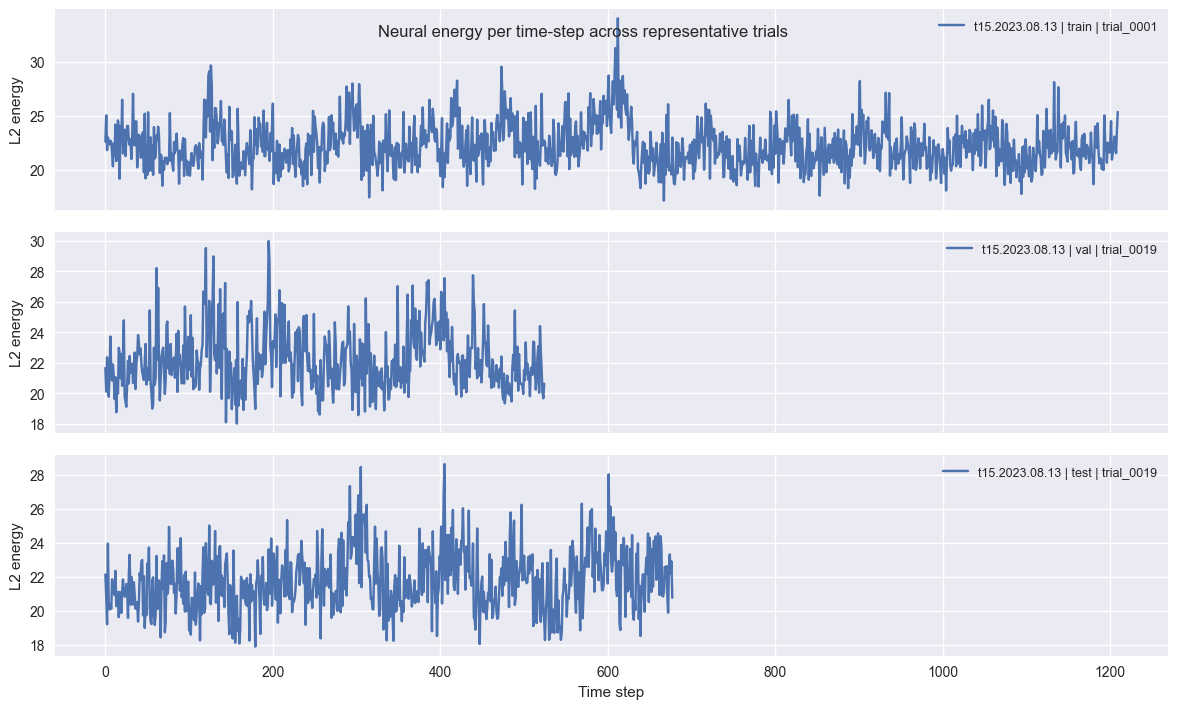

In [15]:
# pick three representative trials across splits
REP_COUNT = 3
sample_rows = pd.concat([
    metadata_df[metadata_df["split"] == split].sample(n=1, random_state=42)
    for split in ["train", "val", "test"]
    if not metadata_df[metadata_df["split"] == split].empty
])
rep_rows = sample_rows.head(REP_COUNT).copy()

fig, axes = plt.subplots(len(rep_rows), 1, figsize=(12, 2.5 * len(rep_rows)), sharex=True)
if len(rep_rows) == 1:
    axes = [axes]
for ax, (_, row) in zip(axes, rep_rows.iterrows()):
    trial_id = row["trial_key"]
    with h5py.File(row["file_path"], "r") as h5_file:
        feats = h5_file[trial_id]["input_features"][:]
    energy = np.linalg.norm(feats, axis=1)
    ax.plot(energy, label=f"{row.session} | {row.split} | {trial_id}")
    ax.set_ylabel("L2 energy")
    ax.legend(loc="upper right", fontsize=9)
axes[-1].set_xlabel("Time step")
fig.suptitle("Neural energy per time-step across representative trials", y=0.92)
plt.tight_layout()
plt.show()

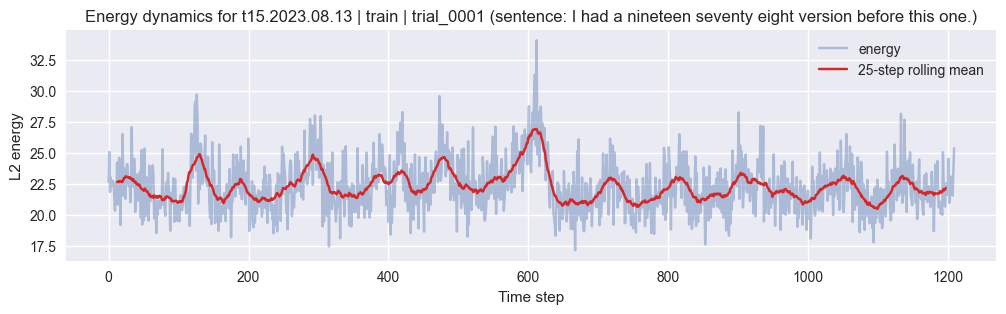

In [16]:
# compute rolling mean energy for a single trial to reveal slower trends
ROLL_WINDOW = 25
row = sample_rows.iloc[0]
trial_id = row["trial_key"]
with h5py.File(row["file_path"], "r") as h5_file:
    feats = h5_file[trial_id]["input_features"][:]
energy = np.linalg.norm(feats, axis=1)
rolling = pd.Series(energy).rolling(ROLL_WINDOW, center=True).mean()

fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(energy, alpha=0.4, label="energy")
ax.plot(rolling, color="tab:red", label=f"{ROLL_WINDOW}-step rolling mean")
ax.set_title(
    f"Energy dynamics for {row.session} | {row.split} | {trial_id} (sentence: {row.sentence_label})"
)
ax.set_xlabel("Time step")
ax.set_ylabel("L2 energy")
ax.legend()
plt.show()

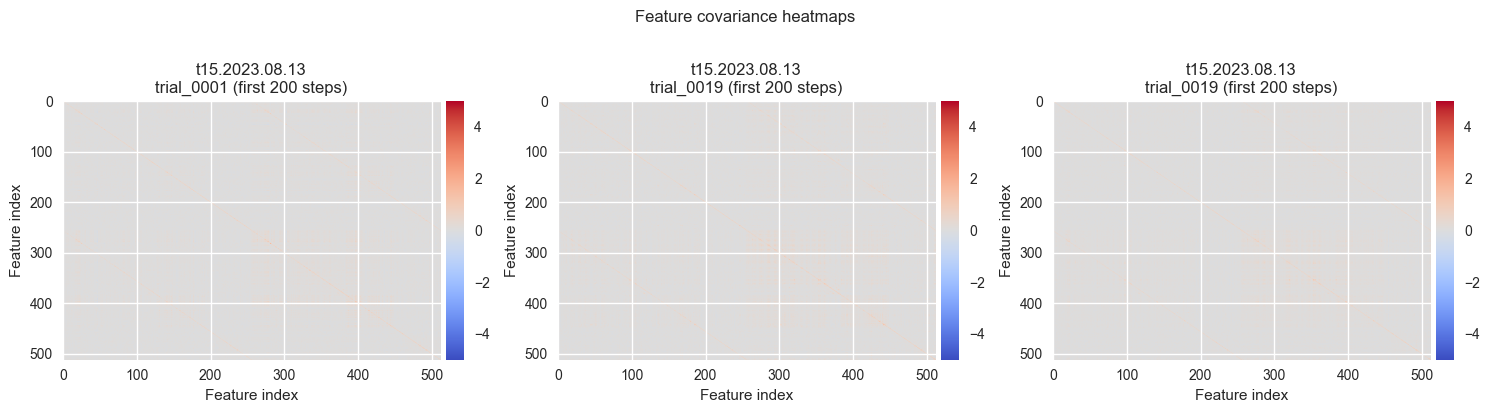

In [17]:
# visualize feature covariance structure for the selected trial subset
from mpl_toolkits.axes_grid1 import make_axes_locatable

cov_records = []
for _, row in rep_rows.iterrows():
    trial_id = row["trial_key"]
    with h5py.File(row["file_path"], "r") as h5_file:
        feats = h5_file[trial_id]["input_features"][:]
    cov = np.cov(feats[:200].T)  # restrict to first 200 time steps for readability
    cov_records.append((row, cov))

fig, axes = plt.subplots(1, len(cov_records), figsize=(5 * len(cov_records), 4))
if len(cov_records) == 1:
    axes = [axes]
for ax, (row, cov) in zip(axes, cov_records):
    trial_id = row["trial_key"]
    im = ax.imshow(cov, aspect="auto", cmap="coolwarm", vmin=-5, vmax=5)
    ax.set_title(f"{row.session}\n{trial_id} (first 200 steps)")
    ax.set_xlabel("Feature index")
    ax.set_ylabel("Feature index")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
plt.suptitle("Feature covariance heatmaps", y=1.02)
plt.tight_layout()
plt.show()

### Signals to image representation